{False, True}


/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide
/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in less
/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in greater


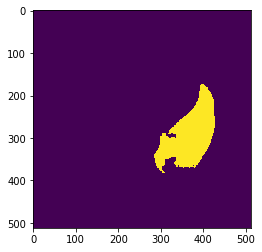

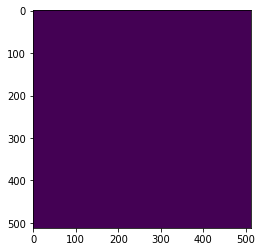

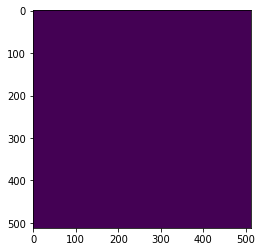

In [13]:
import h5py
import matplotlib.pyplot as plt
import sys
import numpy as np
import cv2
%matplotlib inline
import tensorflow as tf
import scipy

from itertools import cycle

import numpy as np
from scipy import ndimage
from scipy.ndimage import binary_dilation, binary_erosion, \
                        gaussian_filter, gaussian_gradient_magnitude
    
    
    
PATH_MASK_H5 ="/mnt/dfs/xjyan/269-deeplevelset-segmentation/experiments/269_unet2/test/unet2_3_11_predictions.h5"
PATH_INPUT_H5 = "/mnt/dfs/xjyan/patches/269_test_patch_2class.h5"

msk_h5 = h5py.File(PATH_MASK_H5, "r")
input_h5 = h5py.File(PATH_INPUT_H5, "r")

ex_mask, ex_img, ex_nn_mask = None, None, None

for k, g in list(msk_h5.items())[300:]:
    ex_nn_mask = g["binary_mask"][0,:,:,0] 
    ex_img = input_h5[k]["ct_slice"][:,:]

    break

    
    
    
    
### Make this the Snake Class ###    

labels, n=scipy.ndimage.measurements.label(ex_nn_mask)

new_image=scipy.ndimage.measurements.find_objects(labels,max_label=10000000)    

largest_cc_mask = (labels == (np.bincount(labels.flat)[1:].argmax() + 1))


print(set(largest_cc_mask.flatten().tolist()))
plt.figure()
plt.imshow(largest_cc_mask)

for i in range(n):
    if i!=0:
        ex_nn_mask[new_image[i]]=0
        
plt.figure()
plt.imshow(ex_nn_mask)
        
class fcycle(object):
    
    def __init__(self, iterable):
        """Call functions from the iterable each time it is called."""
        self.funcs = cycle(iterable)
    
    def __call__(self, *args, **kwargs):
        f = next(self.funcs)
        return f(*args, **kwargs)

    
    
# SI and IS operators for 2D and 3D.
_P2 = [np.eye(3), np.array([[0,1,0]]*3), np.flipud(np.eye(3)), np.rot90([[0,1,0]]*3)]
_P3 = [np.zeros((3,3,3)) for i in range(9)]

_P3[0][:,:,1] = 1
_P3[1][:,1,:] = 1
_P3[2][1,:,:] = 1
_P3[3][:,[0,1,2],[0,1,2]] = 1
_P3[4][:,[0,1,2],[2,1,0]] = 1
_P3[5][[0,1,2],:,[0,1,2]] = 1
_P3[6][[0,1,2],:,[2,1,0]] = 1
_P3[7][[0,1,2],[0,1,2],:] = 1
_P3[8][[0,1,2],[2,1,0],:] = 1

_aux = np.zeros((0))
def SI(u):
    """SI operator."""
    global _aux
    if np.ndim(u) == 2:
        P = _P2
    elif np.ndim(u) == 3:
        P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions (should be 2 or 3)")
    
    if u.shape != _aux.shape[1:]:
        _aux = np.zeros((len(P),) + u.shape)
    
    for _aux_i, P_i in zip(_aux, P):
        _aux_i[:] = binary_erosion(u, P_i)
    
    return _aux.max(0)

def IS(u):
    """IS operator."""
    global _aux
    if np.ndim(u) == 2:
        P = _P2
    elif np.ndim(u) == 3:
        P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions (should be 2 or 3)")
    
    if u.shape != _aux.shape[1:]:
        _aux = np.zeros((len(P),) + u.shape)
    
    for _aux_i, P_i in zip(_aux, P):
        _aux_i[:] = binary_dilation(u, P_i)
    
    return _aux.min(0)

# SIoIS operator.

SIoIS = lambda u: SI(IS(u))
ISoSI = lambda u: IS(SI(u))
curvop = fcycle([SIoIS, ISoSI])
    

    
smoothing=3
lambda1=1
lambda2=1
iterations=50

levelset=ex_nn_mask


mask = np.double(levelset)
mask[levelset>0]=1

mask[levelset<=0]=0

for i in range(iterations):
    inside = mask>0
    outside = mask<=0


    c0 = ex_img[outside].sum() / float(outside.sum())
    c1 = ex_img[inside].sum() / float(inside.sum())

            # Image attachment.
    dres = np.array(np.gradient(mask))

    abs_dres = np.abs(dres).sum(0)

    aux = abs_dres * (lambda1*(ex_img - c1)**2 - lambda2*(ex_img - c0)**2)
    
    aux.shape

    res = np.copy(mask)
    res[aux < 0] = 1
    res[aux > 0] = 0
    
    
    for j in range(smoothing):
        res = curvop(res)
        
        
    mask=res


plt.figure()
plt.imshow(res)